### EE610: Image Processing
#### Assignment - 4:  Deep Learning and Image Segmentation
#### - Shrey Patel(19D100020)
#### - Neeraj Patidar(19D070039)
##### Updated version with more comments: https://colab.research.google.com/drive/1wzGyozU2UeoBMMaGO5ony2LdXzDie6Tx?usp=sharing

In [ ]:
##adding libraries
import os
import sys
import cv2
import random
import numpy as np
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import backend as K
from google.colab.patches import cv2_imshow
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


##### 1.  Study the challenge statement of MoNuSeg challenge, read the data and display a few training and testing images and their masks (black background, and a random color for each cell nucleus).
>a. Training data is in folders Tissue-Images and Binary-Mask at: https://drive.google.com/drive/folders/1WtpstmwwkweNwkxMfcMgIhbiSNYjclvk?usp=sharing.

>b.  Testing data is in folders Tissue-Images and Binary-Mask at: https://drive.google.com/drive/folders/1ucC1swyylBtaOxzqbH0z4A4Z3B6VBZYV?usp=sharing.

In [ ]:
class DataGenerator(keras.utils.Sequence):                                      #Data generating class
  def __init__(self, path, batch_size = 2, image_size = 256):                   #constructor, initializing image_size, batch_size and path for the data_set
    self.path = path
    self.batch_size = batch_size
    self.image_size = image_size
    self.ids = self.__generateID__();                                           #gets filename of different images
    self.on_epoch_end()
  def __len__(self):                                                            #number of batches
    return int(np.ceil(len(self.ids)/float(self.batch_size)))
  def __getitem__(self, index):                                                 #returns the batch inndexed at index
    batch_ids = self.ids[index*self.batch_size: (index+1)*self.batch_size]
    images = [];
    masks = [];
    for id in batch_ids:
      _image_path = os.path.join(self.path, "Tissue-Images", id)
      _mask_path = os.path.join(self.path, "Binary-Mask", id)
      _image = cv2.imread(_image_path,1)
      _image = cv2.resize(_image,(self.image_size,self.image_size))
      _mask = cv2.imread(_mask_path,1)
      _mask = cv2.resize(_mask,(self.image_size,self.image_size))
      images.append(_image)
      masks.append(_mask)
    images = np.array(images,dtype=np.float32)/255.0
    masks = np.array(masks,dtype=np.float32)/255.0
    return images,masks
  def __generateID__(self):                                                     #id generator
    return os.listdir(os.path.join(self.path,"Tissue-Images"))
  def on_epoch_end(self):
    pass

In [ ]:
#hyper parameters
train_folder = "/content/drive/MyDrive/EE610_Assign4/Train_Data"                #train folder path
test_folder = "/content/drive/MyDrive/EE610_Assign4/Test_Data"                  #test folder path
batch_size = 2
image_size = 1024
train_ids = os.listdir(os.path.join(train_folder,"Tissue-Images"))
val_size = 4
val_ids = train_ids[:4]
train_ids = train_ids[4:]
epochs = 5

        Image                       Mask


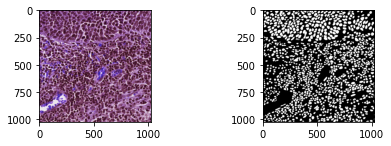

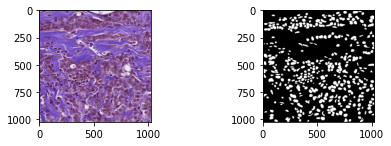

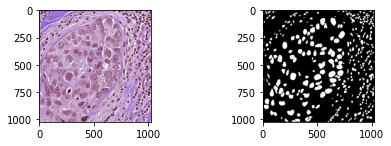

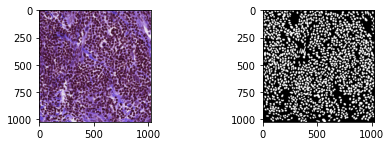

In [ ]:
#some training images with mask
DG_train = DataGenerator(path = train_folder,batch_size = batch_size, image_size = image_size)
print("        Image                       Mask")
_images, _masks = DG_train.__getitem__(5)
for i in range(len(_images)):
  fig = plt.figure()
  fig.subplots_adjust(hspace=1,wspace=1)
  ax = fig.add_subplot(1,2,1)
  ax.imshow(_images[i])                                                         #tissue image
  ax = fig.add_subplot(1,2,2)
  ax.imshow(_masks[i])                                                          #binary image
_images, _masks = DG_train.__getitem__(6)
for i in range(len(_images)):
  fig = plt.figure()
  fig.subplots_adjust(hspace=1,wspace=1)
  ax = fig.add_subplot(1,2,1)
  ax.imshow(_images[i])                                                         #tissue image
  ax = fig.add_subplot(1,2,2)
  ax.imshow(_masks[i])                                                          #binary image

        Image                       Mask


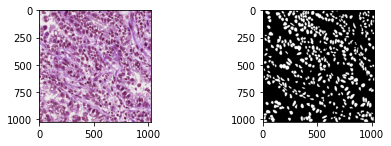

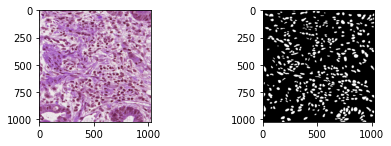

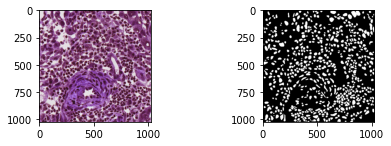

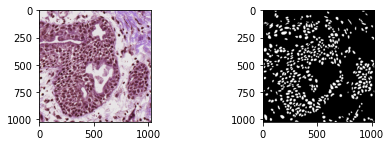

In [ ]:
#some test images with mask
DG_test = DataGenerator(path = test_folder,batch_size = batch_size, image_size = image_size)
print("        Image                       Mask")
_images, _masks = DG_test.__getitem__(1)
for i in range(len(_images)):
  fig = plt.figure()
  fig.subplots_adjust(hspace=1,wspace=1)
  ax = fig.add_subplot(1,2,1)
  ax.imshow(_images[i])
  ax = fig.add_subplot(1,2,2)
  ax.imshow(_masks[i])
_images, _masks = DG_test.__getitem__(3)
for i in range(len(_images)):
  fig = plt.figure()
  fig.subplots_adjust(hspace=1,wspace=1)
  ax = fig.add_subplot(1,2,1)
  ax.imshow(_images[i])
  ax = fig.add_subplot(1,2,2)
  ax.imshow(_masks[i])

##### 2. Code a basic UNet for semantic segmentation in TF+Keras or Pytorch for the binary nucleus vs. non-nucleus segmentation. You may leave a small margin of pixels all around the image from the output.

In [ ]:
def downsample_block(input,filters,kernel_size=(3,3),padding="same",strides=(1,1)):                #downsampling block of UNet architecture
  c = keras.layers.Conv2D(filters,kernel_size,strides,padding,activation='relu')(input)            #
  c = keras.layers.Conv2D(filters,kernel_size,strides,padding,activation='relu')(c)
  ds = keras.layers.MaxPool2D((2,2),(2,2))(c)
  return c,ds
def bottomlayer_block(input,filters,kernel_size=(3,3),padding="same",strides=(1,1)):
  c = keras.layers.Conv2D(filters,kernel_size,strides,padding,activation='relu')(input)
  c = keras.layers.Conv2D(filters,kernel_size,strides,padding,activation='relu')(c)
  return c
def upsample_block(input,copied,filters,kernel_size=(3,3),padding="same",strides=(1,1)):
  us = keras.layers.UpSampling2D(size=(2,2))(input)
  concat = keras.layers.Concatenate()([us,copied])
  uc = keras.layers.Conv2D(filters,kernel_size,strides,padding,activation='relu')(concat)
  uc = keras.layers.Conv2D(filters,kernel_size,strides,padding,activation='relu')(uc)
  return uc

def UNet():
  inputs = keras.layers.Input((image_size,image_size,3))
  filters = [16, 32, 64, 128, 256]

  p0 = inputs

  c1,ds1 = downsample_block(p0,filters[0],(3,3),"same",(1,1))
  c2,ds2 = downsample_block(ds1,filters[1],(3,3),"same",(1,1))
  c3,ds3 = downsample_block(ds2,filters[2],(3,3),"same",(1,1))
  c4,ds4 = downsample_block(ds3,filters[3],(3,3),"same",(1,1))

  c5 = bottomlayer_block(ds4,filters[4],(3,3),"same",(1,1))

  uc4 = upsample_block(c5,c4,filters[3],(3,3),"same",(1,1))
  uc3 = upsample_block(uc4,c3,filters[2],(3,3),"same",(1,1))
  uc2 = upsample_block(uc3,c2,filters[1],(3,3),"same",(1,1))
  uc1 = upsample_block(uc2,c1,filters[0],(3,3),"same",(1,1))

  outputs = keras.layers.Conv2D(1,(1,1),(1,1),"same")(uc1)
  model = keras.models.Model(inputs,outputs)

  return model

##### 3. Train the UNet using Dice loss, and show Dice score on validation and test data. [2]

In [ ]:
# def dice_coef(y_true, y_pred):
#   # y_true_f = K.flatten(y_true)
#   # y_pred_f = K.flatten(y_pred)
#   intersection = K.sum(K.abs(y_true_f*y_pred_f))
#   y_p_sq = K.square(y_pred_f)
#   y_t_sq = K.square(y_true_f)
#   return (2.0 * intersection + 0.0001) / (K.sum(y_t_sq) + K.sum(y_p_sq) + 0.0001)

# def dice_coef_loss(y_true, y_pred):
#   return 1 - dice_coef(y_true, y_pred)

def dice_coef(y_true, y_pred):
  # y_pred=tensorflow.convert_to_tensor(y_pred)
  # y_true=tensorflow.cast(y_true,y_pred.dtype)
  intersection = tensorflow.math.reduce_sum(tensorflow.math.abs(y_true*y_pred))
  y_p = tensorflow.math.square(y_pred)
  y_t = tensorflow.math.square(y_true)
  return (2.0 * intersection + 0.0001) / (tensorflow.math.reduce_sum(y_p) + tensorflow.math.reduce_sum(y_t) + 0.0001)

def dice_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

In [ ]:
model = UNet()
model.compile(optimizer=keras.optimizers.SGD(), loss = [dice_loss], metrics = [dice_coef])
# model.summary()

In [ ]:
train_data = DataGenerator(train_folder,batch_size,image_size)
train_data.ids = train_ids
valid_data = DataGenerator(train_folder,batch_size,image_size)
valid_data.ids = val_ids
train_steps = len(train_ids)//batch_size
val_steps = len(val_ids)//batch_size

model.fit_generator(train_data,validation_data=valid_data,steps_per_epoch=train_steps,validation_steps=val_steps,epochs=epochs)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


13/13 [==============================] - 5s 368ms/step - loss: 0.1770 - dice_coef: 0.8230 - val_loss: 0.1056 - val_dice_coef: 0.8944
Epoch 2/5
13/13 [==============================] - 4s 324ms/step - loss: 0.1716 - dice_coef: 0.8284 - val_loss: 0.0989 - val_dice_coef: 0.9011
Epoch 3/5
13/13 [==============================] - 4s 326ms/step - loss: 0.1658 - dice_coef: 0.8342 - val_loss: 0.0920 - val_dice_coef: 0.9080
Epoch 4/5
13/13 [==============================] - 4s 326ms/step - loss: 0.1597 - dice_coef: 0.8403 - val_loss: 0.0848 - val_dice_coef: 0.9152
Epoch 5/5
13/13 [==============================] - 4s 325ms/step - loss: 0.1532 - dice_coef: 0.8468 - val_loss: 0.0772 - val_dice_coef: 0.9228


In [ ]:
model.save_weights("/content/drive/MyDrive/EE610_Assign4/UNetW_dice.h5")

In [ ]:
test_data = DataGenerator(test_folder,batch_size,image_size)
test_steps = len(test_data.ids)//batch_size
model.evaluate_generator(test_data,steps=test_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.21131722629070282, 0.7886828184127808]

##### 4. Show a few output maps.

1/1 [==============================] - 0s 32ms/step
        True                       Predicted


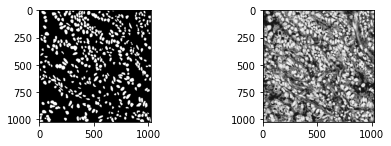

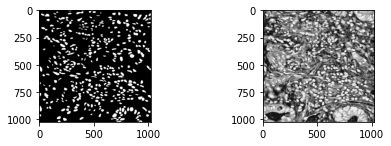

In [ ]:
_images, _masks = test_data.__getitem__(1)
_pred = model.predict(_images)
# _pred = (_pred > 0.5)*1.0
print("        True                       Predicted")
for i in range(len(_images)):
  fig = plt.figure()
  fig.subplots_adjust(hspace=1,wspace=1)
  ax = fig.add_subplot(1,2,1)
  ax.imshow(_masks[i])
  ax = fig.add_subplot(1,2,2)
  ax.imshow(_pred[i].reshape((1024,1024)),cmap='gray')

##### 5. Modify this baseline architecture to study the impact of changing:

>a. Number of blocks in the UNet architecture

>b. Number of filters per layer in the UNet architecture

>c. Loss function as a combination of Dice and MS-SSIM with a trade-off parameter

#### 6. Use watershed segmentation on the probability map produced by the UNet to segment individual nuclei, and show results on test images with touching or overlapping nuclei. Experiment with various parameters of watershed algorithms to try to improve the results.

#### References:

>[1] N. Kumar et al., "A Multi-Organ Nucleus Segmentation Challenge," in IEEE Transactions on Medical Imaging, vol. 39, no. 5, pp. 1380-1391, May 2020, doi: 10.1109/TMI.2019.2947628.

>[2] https://monuseg.grand-challenge.org/Home/

>[3] UNet Architectur: https://www.youtube.com/watch?v=M3EZS__Z_XE

>[4] UNet Architecture: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5

>[5] Dataset Drive Link: https://drive.google.com/drive/folders/1JpKyD15DPxaklERyOBn0Fzapn6sCruH2?usp=share_link